# Generating satellite velocity functions with ``dis``

To run ``dis``, you will need both the ``disSat`` library and ``pyutils/vutils.py``, which can both be found on [my GiHhub](https://github.com/stacykim).  Note that ``dis`` is the name of a pre-existing python module, so importing ``disSat`` as ``dis`` could cause problems if for whatever reason you need both libraries.

Let's import ``dis``  and a few other modules we'll need:

In [1]:
import disSat as dis

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

--> NOTE: for completeness corrections, hard-coding MW NFW parameters to C = 9.0  RS 33.333333333333336 kpc  RVIR 300.0 kpc


If you want to immediately make velocity functions for the Milky Way satellites, then you can go ahead and run:

In [2]:
mwsats = dis.core.MilkyWaySatellites()
mwsats.generate_population()

You can immediately plot the resultant velocity function using a library of built-in plotting functions, and compare it to observed and completeness-corrected Milky Way velocity functions:

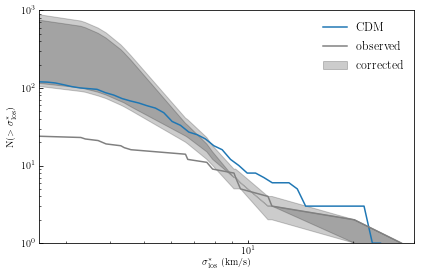

In [3]:
dis.plot.plot_theoretical_velocity_fuction(mwsats, label='CDM')
dis.plot.plot_observed_velocity_function()
dis.plot.plot_corrected_velocity_function(verbose=False)
dis.plot.finalize(legend=True)

## Digging deeper

``dis`` was built to explore the uncertainties in modelling the Milky Way velocity function, so it has a variety of features that let you explore these uncertainties.  Further, it is built in a modular way, so you can easily explore how any of your favorite variations to these uncertainties that _aren't_ already built into ``dis`` affect the resultant velocity function.  We'll get more into integrating your own extensions in the last section of this tutorial.  Here, we'll look at some of the variations that are supported in the current version of ``dis``, and how to explore the full offerings on your own.

One detail to note that will come up multiple times is that the ``mwsats`` object we defined above is an instance of the ``SatellitePopulations`` class.

### The inputs

Exactly what all goes into generating the theoretial velocity function we computed above?  You can view all the input parameters by calling:

In [4]:
mwsats.print_input_parameters()

z_infall : 1.0 (value)
min_mass : 10000000.0 (value)
massdef : 200c (value)
density_profile : mix (value)
mswitch_profile : 500000000.0 (value)
mleft : 1.0 (value)
dark_matter : CDM (class Host)
host : MilkyWay (class DarkMatterModel)
concentration : Diemer19 (class MassConcentration)
smhm : Moster13 (class SMHM)
occupation_fraction : Dooley17 (class OccupationFraction)
rhalf_2D : Read17 (class GalaxySize)
subhalo_mass_function : Moster13 (class SubhaloMassFunction)


Each of the parameters marked with ``(value)`` can be replaced with another value/string.  Note that not all values are currently supported, e.g. using ``massdef=='200m'`` is only partially supported, so may produce undefined behavior).  Those marked with ``(class ...)``, however, will need to be replaced with an object that belongs to the same class type as the object being replaced.  We will explore how to search for and replace these ``class`` input parameters below.

### Sources of scatter

One quick aside on a big thorn in the side of dwarf galaxy models:  scatter.  The key uncertainties that go into modelling the theoretical velocity function are galaxy and halo scaling relations, many of which have significant scatter.  We can see what relations are being used and the input parameters for each of these relations, if any:

In [5]:
mwsats.print_relations()

concentration : Diemer19 
smhm : Moster13 
occupation_fraction : Dooley17 {'reionization_redshift': 9.3}
rhalf_2D : Read17 
subhalo_mass_function : Moster13 {'alpha': 1.84, 'normalization': 0.000854, 'baryon_reduction': 0.8}


Note that these are a subset of the input parameters we saw above!  You can directly call each of these relations, which are defined as functions belonging to the ``SatellitePopulation`` objects:

In [6]:
mwsats.smhm(np.array([1e9,1e10,1e11]))  # give halo masses, returns stellar masses

array([2.30703334e+04, 1.82634968e+06, 1.59959624e+09])

Back to the scatter in these relations.  We can see what the sources of scatter are by calling

In [7]:
mwsats.sources_of_scatter()

{'concentration': True,
 'smhm': True,
 'rhalf_2D': True,
 'subhalo_mass_function': True}

In fact, because of the significant scatter, it's better to generate multiple realizations of the Milky Way satellite population.  The same plotting function above can take as input an array containing multiple ``SatellitePopulation`` objects and plot the median velocity function and its (asymmetric) 1-2 sigma equivalent contours.  Note that running the following will take a several seconds to complete.

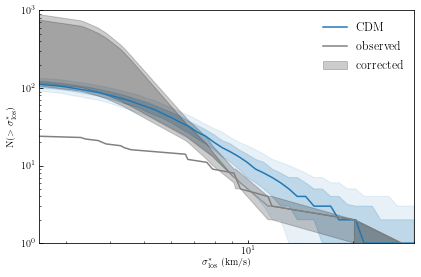

In [8]:
npops = 1000
mw_satpops = [ dis.core.MilkyWaySatellites() for i in range(npops) ]
for satpop in mw_satpops: satpop.generate_population()

dis.plot.plot_theoretical_velocity_fuction(mw_satpops, label='CDM')
dis.plot.plot_observed_velocity_function()
dis.plot.plot_corrected_velocity_function(verbose=False)
dis.plot.finalize(legend=True)

Now for the fun part: variations!  You can turn off the scatter in any or all these relations.  Let's try turning off all the sources of scatter. The ``SatellitePopulation`` objects have a ``set_scatter()`` function that takes a dictionary as input a dictonary containing the name of the source of scatter and the value to set it to (either ``True`` or ``False``), e.g.

In [9]:
mwsats.set_scatter({'smhm': False})

In [10]:
mwsats.sources_of_scatter()

{'concentration': True,
 'smhm': False,
 'rhalf_2D': True,
 'subhalo_mass_function': True}

You can now see that the scatter in the SMHM has been turned off.  For fun, let's try turning off all the sources of scatter that we can, and seeing how that changes the velocity function.  We'll create the velocity function with multiple relations again.

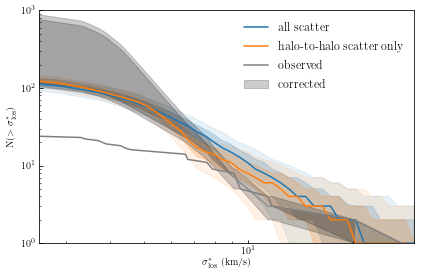

In [11]:
# plot the velocity function we created before with all sources of scatter on first
dis.plot.plot_theoretical_velocity_fuction(mw_satpops, label='all scatter', color='C0')

# generate the new velocity functions without scatter (minus halo-to-halo scatter)
mw_satpops_noscatter = [ dis.core.MilkyWaySatellites() for i in range(npops) ]
for satpop in mw_satpops_noscatter: 
    satpop.set_scatter({'concentration': False, 'smhm': False, 'rhalf_2D': False, 'subhalo_mass_function': False})
    satpop.generate_population()

# plot the new velocity function
dis.plot.plot_theoretical_velocity_fuction(mw_satpops_noscatter, label='halo-to-halo scatter only', color='C1')
dis.plot.plot_observed_velocity_function()
dis.plot.plot_corrected_velocity_function(verbose=False)
dis.plot.finalize(legend=True)

Note that there's one last source of scatter that wasn't turned off:  the scatter that comes from sampling the subhalo mass function ``npops`` number of times, i.e. the halo-to-halo scatter.  It's slight, but you might notice that a feature appears in the velocity function:  a slightly steeper slope around 5-8 km/s.  This is due to a transition between low-mass dwarf galaxies with cuspy central densities and higher-mass galaxies with baryon-driven cores.  A fun exercise to try is to turn various sources of scatter on/off and seeing which ones cause this sharper slope to go away (hint: the answer's [in our paper](https://arxiv.org/abs/2106.09050)).

### Changing scaling relations

You can also change the relations themselves.  Say you wanted to change the SMHM relation.  The method ``dis.list_alternatives()`` takes as input the relation you're currently using (e.g. ``mwsats.smhm``, which as we saw above is set to ``Moster13``), figures out what type of relation it is (e.g. SMHM) and searches the ``dis`` libraries for other such relations.  Let's give it a try:

In [12]:
dis.list_alternatives(mwsats.smhm)

['Behroozi13', 'Brook14', 'Dooley17', 'Moster13']


You can then get your desired relation via:

In [13]:
dis.get_alternative(mwsats.smhm, 'Behroozi13')

In fact you can change ``mwsats.smhm``  to it using this function:

In [14]:
mwsats.smhm = dis.get_alternative(mwsats.smhm, 'Behroozi13')

Let's check that this worked by printing the full list of relations again:

In [15]:
mwsats.print_relations()

concentration : Diemer19 
smhm : Behroozi13 
occupation_fraction : Dooley17 {'reionization_redshift': 9.3}
rhalf_2D : Read17 
subhalo_mass_function : Moster13 {'alpha': 1.84, 'normalization': 0.000854, 'baryon_reduction': 0.8}


Yay!  Alternatively, if you've poked around the ``dis`` libraries and know where your desired relation is, you can shortcut the above and hard-code that in.  In the example above, the path to the ``Behroozi13`` relaton is ``dis.baryons.smhm.Behroozi13``.  You might have noticed that this was printed when we ran ``dis.get_alternative()``.  Let's use this shortcut to generate the velocity function with multiple realizations:

/home/stacykim/libsrc/disSat/baryons/smhm.py:131: UserWarning: Behroozi+ 2013 SMHM relation for z>0 not implemented, using z=0 relation!
  if z != 0: warnings.warn('Behroozi+ 2013 SMHM relation for z>0 not implemented, using z=0 relation!')
/home/stacykim/libsrc/disSat/baryons/smhm.py:136: UserWarning: scatter in Behroozi+ 2013 SMHM relation not quantified, using Moster+ 2013 scatter!
  warnings.warn('scatter in Behroozi+ 2013 SMHM relation not quantified, using Moster+ 2013 scatter!')


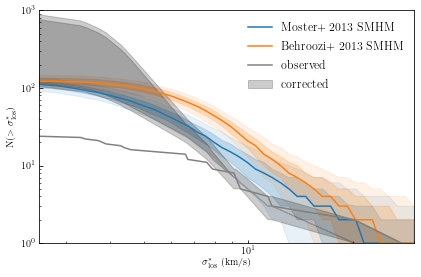

In [16]:
dis.plot.plot_theoretical_velocity_fuction(mw_satpops, label='Moster+ 2013 SMHM', color='C0')

mw_satpops_smhm = [ dis.core.MilkyWaySatellites() for i in range(npops) ]
for satpop in mw_satpops_smhm: 
    satpop.smhm = dis.baryons.smhm.Behroozi13()
    satpop.generate_population()

dis.plot.plot_theoretical_velocity_fuction(mw_satpops_smhm, label='Behroozi+ 2013 SMHM', color='C1')
dis.plot.plot_observed_velocity_function()
dis.plot.plot_corrected_velocity_function(verbose=False)
dis.plot.finalize(legend=True)

For those relations with input parameters, you can modify these by redefining the relation, supplying the value(s) you want for each input parameter in dictionary form.  For instance, based on the list of relations above, you can see that the ``occupation_fraction`` relation we're using, ``Dooley17``, takes ``reionization_redshift`` as an input parameter.  Let's create a dictionary updating the redshift to 11.3 (note: only z = 9.3, 11.3, and 14.4 are supported for ``Dooley17``). We'll call this dictionary ``kwargs`` and pass it onto the new occupation function relation:

In [17]:
kwargs = {'reionization_redshift': 11.3}
mwsats.occupation_fraction = dis.get_alternative(mwsats.occupation_fraction, 'Dooley17', **kwargs)

In [18]:
mwsats.print_relations()

concentration : Diemer19 
smhm : Behroozi13 
occupation_fraction : Dooley17 {'reionization_redshift': 11.3}
rhalf_2D : Read17 
subhalo_mass_function : Moster13 {'alpha': 1.84, 'normalization': 0.000854, 'baryon_reduction': 0.8}


Or more simply, if you know the path to the ``Dooley17`` occupation fraction function:

In [19]:
mwsats.occupation_fraction = dis.baryons.occupation_fraction.Dooley17(reionization_redshift=11.3)

### Accessing satellite properties

Note that you can access the properties of each satellite in a ``SatellitePopulation``, which are stored in a ``properties`` dictionary.  You can thus get the full list of properties via

In [20]:
mwsats.properties.keys()

dict_keys(['mass', 'c200', 'mass_stars', 'rhalf2D', 'density_profile', 'sigLOS'])

and thus get, e.g. a list showing whether each satellite is cored vs cusped via (most are low mass, so will be NFW):

In [21]:
mwsats.properties['density_profile']

array(['nfw', 'nfw', 'nfw', ..., 'nfw', 'nfw', 'nfw'], dtype='<U7')

## Extending ``dis``

The above dealt with variations to the theoretical model that are already supported within ``dis``.  But what if you wanted to introduce your own relations?  Or have a host that's not the Milky Way?  Or adopt a non-standard dark matter model?

``dis`` was built to be highly modular, so that you can easily add modifications of your own.  You can concoct modifications that are quite complex, but I'll cover a few relatively straightforward modifications here, which (I hope) will likely address most desired extensions.  If you want to do something more complex with the code, and aren't quite sure how to proceed and/or run into issues, you're more than welcome to [contact me](mailto:stacyyckim@gmail.com).

### Adding your own relations

Let's start with the simplest extensions:  new scaling relations.  To do this, you'll almost certainly be following a template like this:

```python
from ..relations import Relation  # the number of dots required here (which go
                                  # up one level in the directory tree) could
                                  # vary, depending on where you put this file

from .RelationModule import RelationType  # again the location and name of the file/
                                          # class will vary depending what you implement

class MyRelation22(RelationType):

    name = 'MyRelation22'
    
    def __init__(self, scatter=True):
        self.parameters = {}
        self.sample_scatter = scatter

    @classmethod
    def central_value(cls):
        # add code here

    @staticmethod
    def scatter():
        # add code here
        # depending on the relationship type, could be linear or lognormal scatter

    def __call__(self):
        median = self.central_value()
        if self.sample_scatter:
            # for example, if lognormal scatter
            return median * 10**random.normal(loc=0,scale=self.scatter(),size=len(mass))
        else:
            return median

```

These are the four basic methods each scaling relation built into ``dis`` has.  You may not need to define all four routines for each new relation---in fact, most often, you only need to define the ``central_value()`` and ``scatter()`` methods.  Also, don't forget to give your relation a name (i.e. the ``name`` variable at the top)!  I would highly recommend taking a look under the hood at how other relations of the same type you want to extend are implemented.  You can use ``dis.get_alternative()`` to print out the exact path to the class of relations you want. Most of these will be in the ``disSat/baryons/`` and ``disSat/dark_matter/`` directories.

Where should you put your extensions in?  I would recommend installing it in the appropriate file in either ``disSat/baryons/`` or ``disSat/dark_matter/``, or if you want to keep your mods separate, or have a relation that doesn't fit well in either of these directories, ``disSat/mods/``. No matter where you install them, if they're somewhere in the ``disSat`` directory tree, ``dis.list_alternatives()`` will automatically find them and display them as a possible option whenever similar relations are searched for.  Nifty!

You can also put them outside the ``disSat`` directory.  However, they then won't be searchable with ``dis.list_alternatives()``.

To make things more concrete, let's look at how the stellar mass-size relations are implemented.  This is a snippet from ``disSat/baryons/galaxy_size.py``:

```python
import numpy as np
import numpy.random as random
from ..relations import Relation

class GalaxySize(Relation):

    name = 'GalaxySize'
    
    def __init__(self, scatter=True):
        self.parameters = {}
        self.sample_scatter = scatter

    @classmethod
    def central_value(cls, mstar):
        raise NotImplementedError('This is an abstract class.')

    @staticmethod
    def scatter(cls):
        """Lognormal scatter"""
        raise NotImplementedError('This is an abstract class.')

    def __call__(self, mstar):
        median = self.central_value(mstar)
        if self.sample_scatter:
            return median * 10**random.normal(loc=0,scale=self.scatter(),size=len(mstar))
        else:
            return median

        
############################################################


class Read17(GalaxySize):
    """
    Fit to 2D sizes of isolated dwarfs from Read+ 2017 and McConnachie+ 2012,
    taking out repeats from the latter, and no Leo T.
    """

    name = 'Read17'

    @classmethod
    def central_value(cls, mstar):
        return 10**(0.268*np.log10(mstar)-2.11)

    @staticmethod
    def scatter():
        return 0.234

    
class Danieli18(GalaxySize):
    """
    From Danieli+ 2018, which fit a relation to observed 2D sizes of MW, M31,
    and LG dwarfs, assuming a V-band mass-to-light ratio = 2.0.
    """

    name = 'Danieli18'

    @classmethod
    def central_value(cls, mstar):
        return 10**(0.23*np.log10(mstar)-1.93)

    @staticmethod
    def scatter():
        return 0.29
```

``GalaxySize`` is the name of the stellar mass-size relation class.  You can see that a lognormal scatter has been implemented for this class.  At the end of the snippet that two specific stellar mass-size relations have been defined as _child classes_ of the ``GalaxySize`` class.  For each of these, really the only thing that changes is the scaling relation, implemented in ``central_value()``, the ``scatter`` in the relation, and of course the ``name`` of the relation.  Note that you can have your relation take variables as inputs---here, of course, the stellar masses ``mstar`` are required to compute a galaxy's half-light radii.

If you want to introduce your own stellar mass-size relation, you can just pop it in right at the end of this file---that's probably the most natural place to put it.  But if you'd prefer you can put it in a separate file in ``disSat/baryons/``, or even put it in ``disSat/mods/`` as discussed above---whatever floats your boat!  Don't forget to import both the ``Relations`` and ``GalaxySize`` classes in either of the latter two scenarios.

Last but not least, if you want more complex examples, a good place to look is ``disSat/baryons/occupation_fraction.py``, which defines a supporting routine (a mask so you can separate halos with and without galaxies), and a slightly more involved ``__init__()`` function that requires keyword arguments.  Another good example is ``disSat/dark_matter/subhaloMF.py``, which has even more supporting routines.

### Beyond the Milky Way

What if you wanted to model M31, or the LMC, or the satellites of a massive elliptical that might show up in substructure lensing?  Or a Milky Way analog that has significantly different scaling relations?  In the examples above, we've been using a very specific _child class_ of the ``SatellitePopulation`` _parent class_ called ``MilkyWaySatellites`` that's been tailored spcifically for well... the Milky Way satellites.  You can similarly create your own child class that's tailored to your favorite host halo/galaxy, or your own version of the ``MilkyWaySatellite`` with your own happy mix of scaling relations (note: if you want to just change one scaling relation, it's probably easier to use the syntax above).

Here's a look at how the ``MilkyWaySatellites`` class is defined in ``disSat/core.py``:

```python
class MilkyWaySatellites(SatellitePopulation):

    name = 'MilkyWaySatellites'

    def __init__(self, min_mass=1e7, density_profile='mix', mleft=1.,
                 cosmology=dark_matter.models.CDM()):

        # set parameters
        self.z_infall = 1.
        self.min_mass = min_mass
        self.massdef = '200c'
        self.density_profile = density_profile
        self.mswitch_profile = 5e8 # msun
        self.mleft = mleft

        # set dark matter model and host
        self.dark_matter = cosmology        
        self.host = hosts.MilkyWay(cosmology=cosmology)
        self.host.set_number_of_subhalos(min_mass)
        
        # choose relations
        self.concentration = dark_matter.concentrations.Diemer19(scatter=True)
        self.smhm = baryons.smhm.Moster13(scatter=True)
        self.occupation_fraction = baryons.occupation_fraction.Dooley17(reionization_redshift=9.3)
        self.rhalf_2D = baryons.galaxy_size.Read17(scatter=True)

        # finish setup
        self._finish_setup()
```

For your own custom satellite population, you'll also need at minimum a ``name`` and ``__init__()`` routine.  You can choose whatever keyword arguments you want for the ``__init__()`` function---I chose to include ones where arguably a clear "fiducial" value didn't really exist.  Again, you can define this in ``disSat/core.py``, in ``disSat/mods/``, or a location outside of ``disSat`` (though again, this means it won't be searchable).  You'll also want every single line that ``__init__`` has, although the values/objects you set each of the variables can differ.

If you want to define a host that's not of Milky Way mass, you can define a new ``Host`` object.  The ``Host`` class is defined in ``dis.hosts.py``.  Let's take a look at that class:

```python
from . import relations, dark_matter

class Host:

    name = 'Host'
    
    def __init__(self, cosmology=dark_matter.models.CDM()):
        self.dark_matter = cosmology
        self.subhalo_mass_function = dark_matter.subhaloMF.Moster13(scatter=True)
        
    @staticmethod
    def mass():
        raise NotImplementedError('This is an abstract class')
            
    def set_number_of_subhalos(self, min_mass):
        self.subhalo_min_mass = min_mass
        self.number_of_subhalos = self.subhalo_mass_function.number_of_subhalos(self.mass(), min_mass)

    
class MilkyWay(Host):

    name = 'MilkyWay'
    
    @staticmethod
    def mass():
        return 1e12 # msun     
```

Note that to define the ``MilkyWay`` child class, the only thing I modifed was the host mass.  You can do the same for hosts of different mass (and implement it straight in this file), unless there are extra features you want to add to your host.  Either way, it should then be simple to drop in your new host into your own ``SatellitePopulation`` child class.

### An example alternative dark matter model:  WDM

We'll now address a sightly more complex (and exciting) extension:  adding new dark matter physics!

Dark matter models built into ``dis`` are implemented in ``disSat/dark_matter/models/``.  You can see that there are three models currently supported:

In [22]:
dis.list_alternatives(mwsats.dark_matter)

['CDM', 'WDM', 'SIDM']


All of these models can be accessed as ``dis.dark_matter.models.MODELNAME``.  Let's take a deeper look at one of these: warm dark matter (WDM).  WDM has two main departures from CDM that need to be modelled for the satellite velocity function:  a suppression in the number of low-mass halos, and a suppression in halo concentrations.   

To start, let's switch the dark matter model in ``mwsats`` to WDM, assuming a 6 keV thermal relic, which we specify with the keyword argument ``mWDM``:

In [23]:
mwsats.dark_matter = dis.dark_matter.models.WDM(mWDM=6.)

In [24]:
mwsats.print_relations()

concentration : Diemer19 
smhm : Behroozi13 
occupation_fraction : Dooley17 {'reionization_redshift': 11.3}
rhalf_2D : Read17 
subhalo_mass_function : Moster13 {'alpha': 1.84, 'normalization': 0.000854, 'baryon_reduction': 0.8}
modified_concentration : Schneider12 
transfer_function : Lovell20 {'mu': 1.12, 'beta': 0, 'gamma': 0}


If you compare this list to the original, you can see that there are two new ones:  ``modified concentration`` and ``transfer_function``.  These implement the suppression in halo concentrations and the number of low-mass halos mentioned earlier.

How are these implemented?  If you take a peek into the ``disSat/dark_matter/models/`` directory, you'll see that there's a ``cdm.py`` file implementing CDM (as well as ``sidm.py`` for SIDM), as well as a ``wdm/`` directory.  That in turn contains:

 ```shell
 $ cd disSat/dark_matter/models/wdm
 $ ls
 helper.py
 __init__.py
 transfer_functions.py
 wdm.py
 ```
 
 ``wdm.py`` is the backbone of the WDM extension.  Let's take a look within:
 
 ```python
import numpy as np
import numpy.random as random

import colossus
cosmo = colossus.cosmology.cosmology.setCosmology('planck18')

from ....relations import Relation
from ... import concentrations, subhaloMF
from ..skeleton import ModifiedConcentration, DarkMatterModel
from .helper import half_mode_mass
from . import transfer_functions


class WDM(DarkMatterModel):

    name = 'WDM'

    def __init__(self, mWDM=3.):
        self.mWDM = mWDM
        self.parameters = {'mWDM': self.mWDM}
        self.modified_concentration = Schneider12()
        self.transfer_function = transfer_functions.Lovell20()


############################################################
# WDM concentration
        
class Schneider12(ModifiedConcentration):
    """
    Based on Schneider+ 2012 (parameters to convert cCDM
    to cWDM via their eq. 39).  Assumes masses are in 200c units.
    """

    name = 'Schneider12'
    
    def __call__(self, mass, cCDM, dark_matter_model, z=0.):

        mWDM = dark_matter_model.mWDM

        GAMMA1 = 15.
        GAMMA2 = 0.3
        h0 = cosmo.Hz(z)/100.
        
        # Schneider+ 2012 uses rho_bar in mass def, so must convert
        m1m_div_h, r1m_div_h, c1m = colossus.halo.mass_defs.changeMassDefinition(mass/h0, cCDM, z, '200c', '1m')
        m1m = m1m_div_h * h0

        return cCDM * (1 + GAMMA1*half_mode_mass(mWDM)/m1m)**(-GAMMA2)
```

A few things to note here:

1. All dark matter models should be defined as a ``DarkMatterModel`` child class, and have ``self.parameters``defined (even if the former is just an empty dictionary).  The rest is up to you.


2. Import your new dark matter model in ``disSat/dark_matter/models/__init__.py``.  This serves as a centralized directory from which all dark matter models can be imported.


3. The concentrations are defined as a ``ModifiedConcentration`` child class.  When assigning concentrations to halos, the machinery checks if the dark matter model includes a ``ModifiedConcentration`` relation and modified accordingly if it exists (more on this below).

With regards to how the WDM concentration and transfer function are integrated into the velocity function calculation, this is an area I'm actually not completely happy with at the moment.  It currently requires edits in a few different places, but I'd prefer for it to be self-contained in the ``wdm/`` directory.  The new WDM relations are all defined within the ``wdm/`` directory---the concentration suppression ``Schneider12()`` is defined at the end of ``wdm.py``, and the transfer function in its own ``transfer_function.py`` file (because there are so many published transfer functions!).  But I had to make a few modifications in the ``SatellitePopulation`` object to put these relations to use.  All such modifications I had to make are:

```python
class SatellitePopulation:
    
    [...]

    def _sample_subhalo_masses(self):
        m = self.host.subhalo_mass_function(self.min_mass, self.host.mass(),
                                            self.host.number_of_subhalos)
        if isinstance(self.dark_matter, dark_matter.models.WDM):
            tf = self.dark_matter.transfer_function(m, self.dark_matter.mWDM)
            mask = np.less_equal(random.random(size=len(m)), tf)
            self.host.number_of_subhalos = sum(mask)
            return m[mask]
        else:
            return m
        
    def _sample_concentrations(self):
        c = self.concentration(self.properties['mass'], self.z_infall)
        relations = self.get_relations()
        for name,relation in relations.items():
            if isinstance(relation, dark_matter.models.ModifiedConcentration):
                cmod = relation(self.properties['mass'], c, self.dark_matter, z=self.z_infall)
                return cmod
        return c

    [...]
```

The transfer function is implemented in ``_sample_subhalo_masses()``, and the concentration suppression in ``_sample_concentrations()``.  I was hoping to implement the ``WDM`` class as a wrapper class of sorts, so that no changes had to be made to the ``SatellitePopulation`` object, and instead the ``WDM`` class would intelligently pick up when these two functions were being called, and appropriately modify the calls.  But after reading multiple tutorials on wrapper functions and wrapper classes(!), I was still scratching my head, and gave up.  If you have any ideas on how to implement this, I'm all ears. :)

All that aside, let's generate a WDM velocity function!  With the transfer function suppression, Poisson noise becomes ever more importnat, so let's probe the scatter by generating multiple WDM realizations of the Milky Way satellite population:

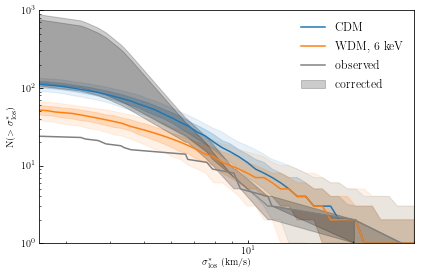

In [25]:
dis.plot.plot_theoretical_velocity_fuction(mw_satpops, label='CDM', color='C0')

mw_satpops_wdm = [ dis.core.MilkyWaySatellites() for i in range(npops) ]
for satpop in mw_satpops_wdm:
    satpop.dark_matter = dis.dark_matter.models.WDM(mWDM=6.)
    satpop.generate_population()

dis.plot.plot_theoretical_velocity_fuction(mw_satpops_wdm, label='WDM, 6 keV', color='C1')
dis.plot.plot_observed_velocity_function()
dis.plot.plot_corrected_velocity_function(verbose=False)
dis.plot.finalize(legend=True)

Looks ruled out to me! :P